In [ ]:
# ===== Unique KOSPI tickers -> Yahoo Close -> price.csv =====
# 요구 패키지: pandas, numpy, yfinance, tqdm  (없으면 pip install)
import os
import re
import math
import warnings
from datetime import datetime
from typing import List, Tuple, Dict

import pandas as pd
import numpy as np

try:
    from tqdm import tqdm
except ImportError:
    # tqdm 미설치 시 대체
    def tqdm(x, **kwargs):
        return x

import yfinance as yf

In [ ]:
# ---------------------------
# 0) 기본 설정 (지침서 값 반영: 날짜는 필요시 변경)
# ---------------------------
CSV_INPUT = "dt.csv"            # 설문 원본 파일명
PRICE_CSV = "price.csv"         # 저장 파일명

# 인샘플/아웃샘플을 모두 커버하도록 넓게 지정 (필요 시 조정)
START_DATE = "2023-03-25"       # 지침 예: 설문일 기준 2년 추정 시작
END_DATE   = "2025-09-27"       # 지침 예: 오늘-1영업일 근처 (2025-09-27)

CLOSE_COL_PREFERENCE = "Close"  # Close 고정 사용
MIN_ROWS_KEEP = 5               # 5개 미만 데이터면 무의미로 간주해 제외



In [ ]:

# ---------------------------
# 1) 헬퍼: 설문 CSV에서 고유 티커 뽑기
# ---------------------------
def extract_unique_ks_tickers(csv_path: str) -> List[str]:
    """
    설문 CSV를 문자열로 읽고 C1_i_2(티커 컬럼)에서 고유 티커 추출.
    - CSV는 dtypes=str로 읽어 앞 0 보존
    - 티커는 6자리 제로패딩 후 .KS 접미사
    """
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"CSV not found: {csv_path}")

    df = pd.read_csv(csv_path, dtype=str)
    # 티커 컬럼 패턴: C1_i_2
    ticker_cols = [c for c in df.columns if re.fullmatch(r"C1_\d+_2", c)]
    if not ticker_cols:
        warnings.warn("티커 컬럼(C1_i_2 패턴)을 찾지 못했습니다. 빈 리스트 반환.")
        return []

    raw = df[ticker_cols].values.ravel().tolist()
    raw = [str(x).strip() for x in raw if pd.notna(x) and str(x).strip() != ""]

    normed = []
    for t in raw:
        # 숫자/하이픈/공백 제거
        t_clean = re.sub(r"[^0-9]", "", t)
        if t_clean == "":
            continue
        # 6자리 제로패딩 후 .KS
        t6 = t_clean.zfill(6)
        normed.append(f"{t6}.KS")

    unique_sorted = sorted(set(normed))
    return unique_sorted



In [ ]:

# ---------------------------
# 2) yfinance 다운로드: Close만 정리
# ---------------------------
def _extract_close_from_yf(df_prices: pd.DataFrame, tickers: List[str]) -> pd.DataFrame:
    """
    yfinance.download 결과에서 Close만 뽑아 DataFrame columns=tickers 형태로 정리.
    yfinance는 버전에 따라 (col, ticker) 혹은 (ticker, col) MultiIndex를 반환할 수 있어
    양쪽을 모두 처리.
    """
    if df_prices.empty:
        return pd.DataFrame()

    # 이미 단일계열(Series)로 오면 곧장 반환 불가 -> DataFrame로 변경 고려
    if isinstance(df_prices, pd.Series):
        df_prices = df_prices.to_frame(name=CLOSE_COL_PREFERENCE)

    # MultiIndex 형태 처리
    if isinstance(df_prices.columns, pd.MultiIndex):
        # 두 가지 케이스를 모두 시도
        close_df = None
        # 케이스 1: top-level이 'Close' 인 경우
        if CLOSE_COL_PREFERENCE in df_prices.columns.get_level_values(0):
            try:
                tmp = df_prices[CLOSE_COL_PREFERENCE].copy()
                # 컬럼이 티커로 되어 있다고 가정
                close_df = tmp
            except Exception:
                pass
        # 케이스 2: top-level이 티커 인 경우
        if close_df is None:
            try:
                # 각 티커의 Close를 뽑아 붙임
                pieces = []
                for t in tickers:
                    if t in df_prices.columns.get_level_values(0):
                        sub = df_prices[t]
                        if CLOSE_COL_PREFERENCE in sub.columns:
                            s = sub[CLOSE_COL_PREFERENCE].rename(t)
                            pieces.append(s)
                if pieces:
                    close_df = pd.concat(pieces, axis=1)
            except Exception:
                pass
        if close_df is None:
            # 최후: 'Close' 레벨만 갖고 오기
            try:
                close_mask = df_prices.columns.get_level_values(0) == CLOSE_COL_PREFERENCE
                tmp = df_prices.loc[:, close_mask]
                # 레벨 순서 통일: columns=(Close, TICKER) -> TICKER만 남기기
                tmp.columns = tmp.columns.get_level_values(1)
                close_df = tmp
            except Exception:
                raise ValueError("yfinance 결과에서 Close 컬럼을 식별하지 못했습니다.")
        return close_df

    # SingleIndex 형태: 종종 'Close' 하나만 오는 케이스를 가정
    if CLOSE_COL_PREFERENCE in df_prices.columns:
        # 단일 종목일 경우 컬럼명이 'Close' 하나뿐 -> 컬럼명을 티커로 바꾸긴 어려움
        # 호출단에서 단일 종목이면 개별 다운로드로 처리하므로 여기선 그대로 반환
        return df_prices[[CLOSE_COL_PREFERENCE]].copy()

    # 혹시 'Adj Close'만 온 경우 등 예외
    possible = [c for c in df_prices.columns if c.lower() == "close"]
    if possible:
        return df_prices[possible].copy()

    raise ValueError("Close 컬럼을 찾을 수 없습니다.")


def download_close_batch(tickers: List[str], start: str, end: str) -> pd.DataFrame:
    """
    여러 티커를 한 번에 yfinance.download로 받아 Close만 모은다.
    일부 티커가 빠질 수 있으므로, 후속 보정으로 단건 재시도 권장.
    """
    if not tickers:
        return pd.DataFrame()

    raw = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        interval="1d",
        group_by="ticker",
        auto_adjust=False,
        actions=False,
        progress=False,
        threads=True,
    )
    close_df = _extract_close_from_yf(raw, tickers)
    # 인덱스 날짜 정리
    close_df.index = pd.to_datetime(close_df.index)
    # 컬럼 순서 정렬
    close_df = close_df.loc[:, sorted([c for c in close_df.columns if c in tickers])]
    return close_df


def download_close_single(ticker: str, start: str, end: str) -> pd.Series:
    """
    단일 티커 Close만 반환 (Series: index=date, name=ticker).
    """
    raw = yf.download(
        tickers=ticker,
        start=start,
        end=end,
        interval="1d",
        group_by="ticker",
        auto_adjust=False,
        actions=False,
        progress=False,
        threads=False,
    )
    if raw is None or raw.empty:
        return pd.Series(dtype=float, name=ticker)

    # 단일은 일반적으로 SingleIndex
    if CLOSE_COL_PREFERENCE in raw.columns:
        s = raw[CLOSE_COL_PREFERENCE].copy()
    else:
        # MultiIndex나 기타 케이스 보정
        tmp = _extract_close_from_yf(raw, [ticker])
        if tmp.empty:
            return pd.Series(dtype=float, name=ticker)
        if tmp.shape[1] == 1:
            s = tmp.iloc[:, 0]
        else:
            # 혹시 컬럼명이 맞지 않으면 첫 컬럼 사용
            s = tmp.iloc[:, 0]
    s.index = pd.to_datetime(s.index)
    s.name = ticker
    return s


In [ ]:


# ---------------------------
# 3) 증분 저장 로직: price.csv 병합/업데이트
# ---------------------------
def load_existing_prices(path: str) -> pd.DataFrame:
    if not os.path.exists(path):
        return pd.DataFrame()
    df = pd.read_csv(path, parse_dates=[0], index_col=0)
    # 인덱스가 날짜로 인식되었는지 확인
    if not np.issubdtype(df.index.dtype, np.datetime64):
        df.index = pd.to_datetime(df.index, errors="coerce")
    return df


def merge_prices(old: pd.DataFrame, new: pd.DataFrame) -> pd.DataFrame:
    """
    기존 price.csv와 신규 수집 데이터 병합.
    - 동일 날짜/티커는 신규값으로 덮어씀
    - 열/행 기준 outer union
    """
    if old is None or old.empty:
        out = new.copy()
    elif new is None or new.empty:
        out = old.copy()
    else:
        out = old.combine_first(new).combine_first(old)  # 양방향 보정
        # 동일 셀에 값이 겹치면 신규(new)을 우선 적용
        # combine_first로는 신규 우선이 어려워, concat 후 마지막 등장값 우선으로 덮기
        tmp = pd.concat([old, new]).sort_index()
        # 같은 인덱스 중 마지막(=new)이 아래 있으니 groupby last로 선택
        out = tmp.groupby(tmp.index).last()
    # 컬럼 정렬
    out = out.loc[:, sorted(out.columns)]
    # 행 정렬
    out = out.sort_index()
    return out




In [ ]:
# ---------------------------
# 4) 메인: 실행 파이프라인
# ---------------------------
def main():
    # 1) 설문에서 고유 티커 추출
    tickers = extract_unique_ks_tickers(CSV_INPUT)
    if not tickers:
        print("설문에서 유효한 KOSPI 티커를 찾지 못했습니다. 종료합니다.")
        return
    print(f"설문 고유 티커 수: {len(tickers)}")

    # 2) 기존 price.csv 로드 (증분 업데이트 대비)
    df_exist = load_existing_prices(PRICE_CSV)
    have_cols = set(df_exist.columns) if not df_exist.empty else set()

    # 3) 우선 배치 다운로드 (대부분 커버)
    df_batch = download_close_batch(tickers, START_DATE, END_DATE)
    if df_batch is None:
        df_batch = pd.DataFrame()
    got_cols = set(df_batch.columns) if not df_batch.empty else set()

    # 4) 배치에서 빠진 티커는 개별 재시도
    missing = [t for t in tickers if t not in got_cols]
    if missing:
        print(f"배치에서 누락된 티커 수: {len(missing)} -> 개별 재시도")
        pieces = []
        for t in tqdm(missing, desc="single re-download"):
            s = download_close_single(t, START_DATE, END_DATE)
            if s is not None and not s.dropna().empty:
                pieces.append(s)
        if pieces:
            df_single = pd.concat(pieces, axis=1)
            # 너무 짧은 열 제거(노이즈/상장직후 등)
            short_cols = [c for c in df_single.columns if df_single[c].dropna().shape[0] < MIN_ROWS_KEEP]
            df_single = df_single.drop(columns=short_cols, errors="ignore")
        else:
            df_single = pd.DataFrame()
    else:
        df_single = pd.DataFrame()

    # 5) 신규 데이터 합치기
    df_new = df_batch
    if not df_single.empty:
        df_new = df_new.join(df_single, how="outer") if not df_new.empty else df_single

    # 6) 기존과 병합 & 저장
    df_out = merge_prices(df_exist, df_new)
    # 완전 결측 컬럼 제거(다운로드 완전 실패 종목)
    all_na_cols = [c for c in df_out.columns if df_out[c].isna().all()]
    if all_na_cols:
        warnings.warn(f"완전 결측 종목 {len(all_na_cols)}개 제거: {all_na_cols[:5]}{' ...' if len(all_na_cols)>5 else ''}")
        df_out = df_out.drop(columns=all_na_cols, errors="ignore")

    # 열 이름이 .KS로 끝나는지 최종 점검
    bad_cols = [c for c in df_out.columns if not re.fullmatch(r"\d{6}\.KS", str(c))]
    if bad_cols:
        warnings.warn(f"비표준 티커 컬럼이 감지되어 그대로 저장합니다: {bad_cols}")

    df_out = df_out.dropna()
    df_out.to_csv(PRICE_CSV, encoding="utf-8-sig")
    print(f"저장 완료: {PRICE_CSV} (행={df_out.shape[0]}, 열={df_out.shape[1]})")


if __name__ == "__main__":
    main()


설문 고유 티커 수: 469
저장 완료: price.csv (행=158, 열=469)


Saved individual NAVs → out/backtest_nav_individual_all.csv (rows=124, cols=1280)


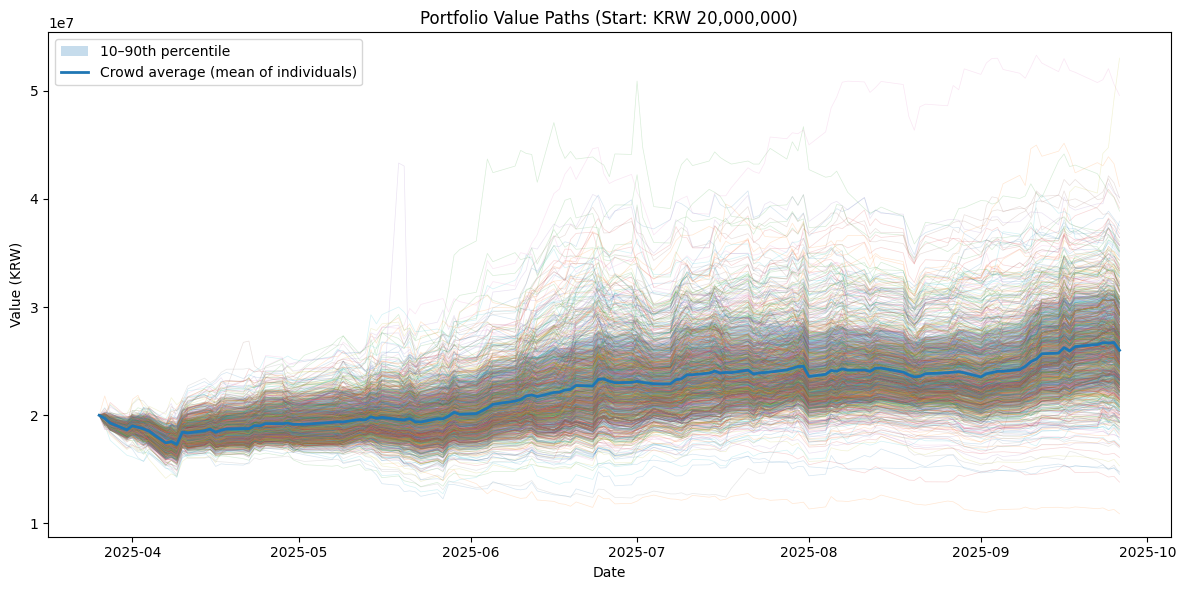

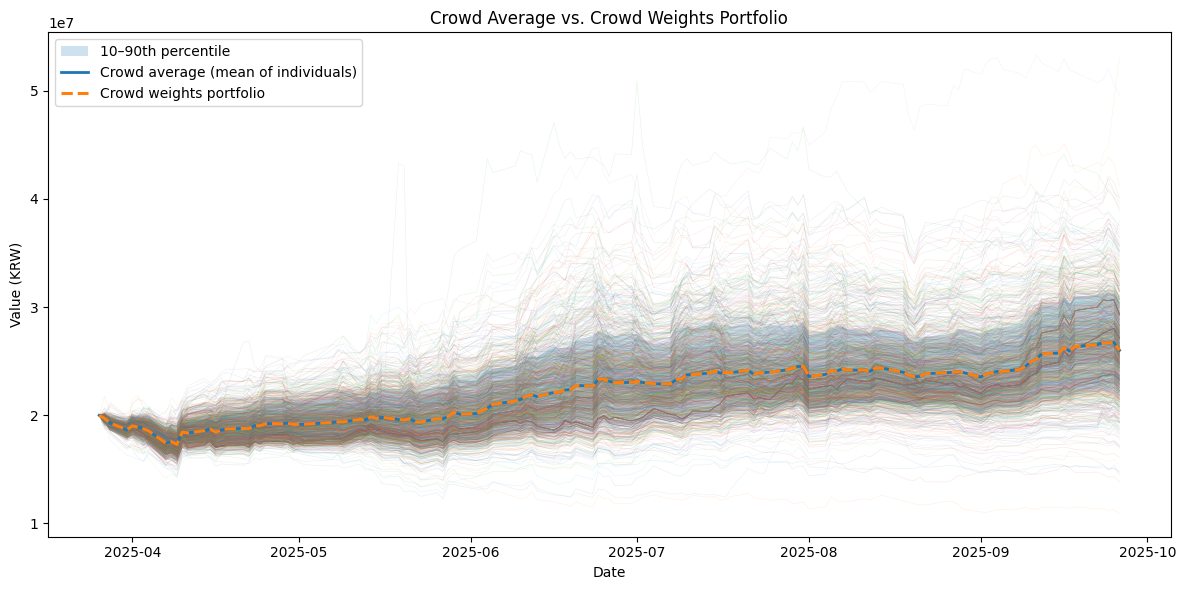


=== Individual Performance (top 10 by AnnReturn) ===
      AnnReturn  AnnVol   Sharpe  TotalReturn     MDD  Days
ID                                                         
744      6.3695  0.4699  13.5539       1.6509 -0.1127   124
679      5.4186  0.4875  11.1153       1.4780 -0.1805   124
2259     3.3852  0.4103   8.2504       1.0576 -0.1373   124
574      3.1709  0.5108   6.2074       1.0079 -0.1458   124
629      3.1580  0.5182   6.0941       1.0048 -0.1916   124
1832     3.0599  0.4446   6.8820       0.9816 -0.1471   124
481      2.9595  0.4724   6.2642       0.9575 -0.1899   124
507      2.9031  0.7173   4.0471       0.9439 -0.2960   124
1072     2.7139  0.3473   7.8148       0.8973 -0.1458   124
216      2.6263  0.4581   5.7330       0.8753 -0.1762   124


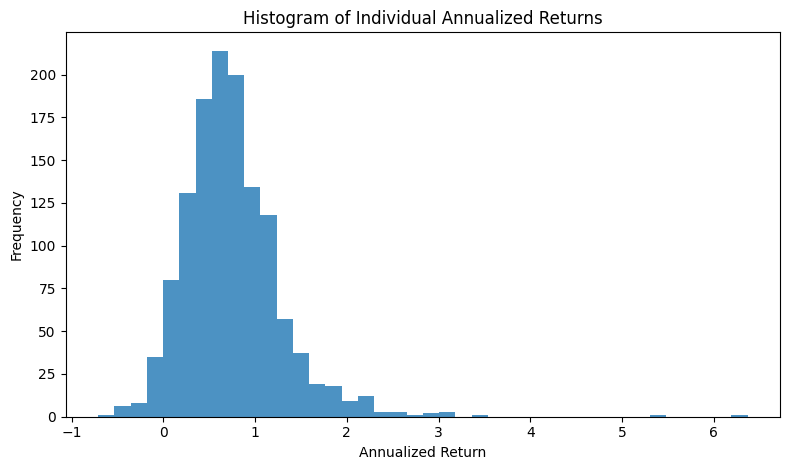


=== Average of Individual Metrics ===
             AverageAcrossIndividuals
AnnReturn                      0.7522
AnnVol                         0.3099
Sharpe                         2.3772
TotalReturn                    0.3005
MDD                           -0.1535
Days                         124.0000


In [ ]:
# ===== Individual NAVs + Crowd Weights Portfolio + Performance Summary =====
import pandas as pd
import numpy as np
import re, os
import matplotlib.pyplot as plt

# -------------------
# Paths / Params
# -------------------
DT_CSV      = "dt.csv"         # survey raw
PRICE_CSV   = "price.csv"      # Close time series (Date x Ticker)
OUT_DIR     = "out"
OUT_CSV_ALL = os.path.join(OUT_DIR, "backtest_nav_individual_all.csv")

TOTAL_CAPITAL = 20_000_000     # KRW 20M
EXEC_DATE     = "2025-03-26"   # execution date
OOS_END       = "2025-09-27"   # test end date
RF            = 0.0            # risk-free rate for Sharpe (annual)

os.makedirs(OUT_DIR, exist_ok=True)

# -------------------
# Load data
# -------------------
df_dt  = pd.read_csv(DT_CSV, dtype=str)
prices = pd.read_csv(PRICE_CSV, index_col=0, parse_dates=[0]).sort_index()

# slice test window (exec ~ end)
oos_start = pd.to_datetime(EXEC_DATE)
oos_end   = pd.to_datetime(OOS_END)
prices = prices.loc[(prices.index >= oos_start) & (prices.index <= oos_end)].copy()

# execution day adjust (next valid trading day)
exec_idx = prices.index.get_indexer([oos_start], method="bfill")
if (len(exec_idx) == 0) or (exec_idx[0] == -1):
    raise ValueError("No valid trading day on/after execution date in price.csv")
exec_day = prices.index[exec_idx[0]]

# -------------------
# Helpers
# -------------------
def parse_response(row) -> dict:
    """Extract {ticker: amount in 10k KRW} from a survey row."""
    alloc = {}
    for i in range(1, 16):
        t_col, a_col = f"C1_{i}_2", f"C1_{i}_3"
        if t_col not in row or a_col not in row:
            continue
        t_raw, a_raw = row[t_col], row[a_col]
        if pd.isna(t_raw) or pd.isna(a_raw):
            continue
        t_clean = re.sub(r"[^0-9]", "", str(t_raw))
        if not t_clean:
            continue
        ticker = f"{t_clean.zfill(6)}.KS"
        try:
            amt = float(str(a_raw).replace(",", "").strip())
        except:
            continue
        if amt > 0:
            alloc[ticker] = alloc.get(ticker, 0.0) + amt
    return alloc

def compute_shares_from_weights(weights: dict, px_exec: pd.Series, total_capital: float) -> dict:
    """weights: {ticker: weight}, px_exec: prices at exec_day for those tickers."""
    shares = {}
    for t, w in weights.items():
        px = px_exec.get(t, np.nan)
        if pd.notna(px) and px > 0 and w > 0:
            shares[t] = (total_capital * w) / px
    return shares

def nav_from_shares(shares: dict, prices: pd.DataFrame, exec_day: pd.Timestamp, total_capital: float) -> pd.Series:
    """Compute NAV path from constant shares; scale to exactly total_capital at exec_day."""
    if not shares:
        return None
    tickers = list(shares.keys())
    nav_series = (prices[tickers] * pd.Series(shares)).sum(axis=1)
    nav_series = nav_series.reindex(prices.index)
    # scale so that NAV(exec_day) == total_capital
    if pd.notna(nav_series.loc[exec_day]) and nav_series.loc[exec_day] != 0:
        nav_series = nav_series * (total_capital / nav_series.loc[exec_day])
    nav_series.name = "NAV"
    return nav_series

def perf_metrics_from_nav(nav: pd.Series, rf_annual: float = 0.0) -> dict:
    """Compute performance metrics from NAV path."""
    nav = nav.dropna()
    if nav.shape[0] < 2:
        return {"AnnReturn": np.nan, "AnnVol": np.nan, "Sharpe": np.nan,
                "TotalReturn": np.nan, "MDD": np.nan, "Days": nav.shape[0]}
    rets = nav.pct_change().dropna()
    n = rets.shape[0]
    if n == 0:
        return {"AnnReturn": np.nan, "AnnVol": np.nan, "Sharpe": np.nan,
                "TotalReturn": np.nan, "MDD": np.nan, "Days": nav.shape[0]}
    # annualization by trading days
    total_return = nav.iloc[-1] / nav.iloc[0] - 1.0
    ann_return = (nav.iloc[-1] / nav.iloc[0]) ** (252.0 / n) - 1.0
    ann_vol = rets.std(ddof=1) * np.sqrt(252.0)
    sharpe = (ann_return - rf_annual) / ann_vol if (ann_vol > 0) else np.nan
    # max drawdown
    cummax = nav.cummax()
    dd = nav / cummax - 1.0
    mdd = dd.min()
    return {
        "AnnReturn": ann_return,
        "AnnVol": ann_vol,
        "Sharpe": sharpe,
        "TotalReturn": total_return,
        "MDD": mdd,
        "Days": int(nav.shape[0]),
    }

# -------------------
# 1) Build all individual NAVs (concat once)
# -------------------
nav_map = {}           # respondent -> NAV series
weights_map = {}       # respondent -> weight dict (normalized, only tickers in prices)
for _, row in df_dt.iterrows():
    if "No" not in row or pd.isna(row["No"]):
        continue
    respondent = str(row["No"]).strip()

    alloc = parse_response(row)
    if not alloc:
        continue
    amt_total = sum(alloc.values())
    if amt_total <= 0:
        continue

    # only tickers available in prices columns
    weights = {t: v / amt_total for t, v in alloc.items() if t in prices.columns}
    if not weights:
        continue
    weights_map[respondent] = weights

    # shares and NAV
    px_exec = prices.loc[exec_day, list(weights.keys())]
    shares = compute_shares_from_weights(weights, px_exec, TOTAL_CAPITAL)
    if not shares:
        continue
    nav = nav_from_shares(shares, prices, exec_day, TOTAL_CAPITAL)
    if nav is None:
        continue
    nav.name = respondent
    nav_map[respondent] = nav

# concat all NAVs
nav_all = pd.concat(nav_map.values(), axis=1) if nav_map else pd.DataFrame(index=prices.index)
nav_all.index.name = "Date"
# optional save for your records (you can comment out if not needed)
nav_all.to_csv(OUT_CSV_ALL, encoding="utf-8-sig")
print(f"Saved individual NAVs → {OUT_CSV_ALL} (rows={nav_all.shape[0]}, cols={nav_all.shape[1]})")

# -------------------
# 2) Crowd average path & percentile bands (English labels; no saving)
# -------------------
crowd_avg = nav_all.mean(axis=1, skipna=True)
p10 = nav_all.quantile(0.10, axis=1, interpolation="linear")
p90 = nav_all.quantile(0.90, axis=1, interpolation="linear")

mask = (~crowd_avg.isna()) & (~p10.isna()) & (~p90.isna())
x = nav_all.index[mask]
y_mean = crowd_avg[mask].values
y_p10  = p10[mask].values
y_p90  = p90[mask].values

plt.figure(figsize=(12, 6))
# individuals
for col in nav_all.columns:
    plt.plot(nav_all.index, nav_all[col], linewidth=0.5, alpha=0.18)
# band + crowd mean
plt.fill_between(x, y_p10, y_p90, alpha=0.25, label="10–90th percentile")
plt.plot(x, y_mean, linewidth=2.0, label="Crowd average (mean of individuals)")
plt.title("Portfolio Value Paths (Start: KRW 20,000,000)")
plt.xlabel("Date")
plt.ylabel("Value (KRW)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# -------------------
# 3) Crowd weights portfolio (built from average weights) & visualization
# -------------------
# Build respondent weight vectors aligned to universe, then average
w_series_list = []
for resp, w in weights_map.items():
    s = pd.Series(w, name=resp).reindex(prices.columns).fillna(0.0)
    w_series_list.append(s)
if w_series_list:
    W = pd.concat(w_series_list, axis=1)  # rows: tickers, cols: respondents
    w_crowd = W.mean(axis=1)
    # normalize strictly to sum=1 over positive entries
    w_crowd = w_crowd.where(w_crowd > 0, 0.0)
    if w_crowd.sum() > 0:
        w_crowd = w_crowd / w_crowd.sum()
else:
    w_crowd = pd.Series(dtype=float, index=prices.columns).fillna(0.0)

# shares & NAV for crowd weights portfolio
tickers_crowd = list(w_crowd[w_crowd > 0].index)
px_exec_crowd = prices.loc[exec_day, tickers_crowd] if len(tickers_crowd) else pd.Series(dtype=float)
shares_crowd  = compute_shares_from_weights(w_crowd[w_crowd > 0].to_dict(), px_exec_crowd, TOTAL_CAPITAL)
nav_crowd     = nav_from_shares(shares_crowd, prices, exec_day, TOTAL_CAPITAL) if shares_crowd else None

# visualize crowd weights portfolio against crowd average & band
if nav_crowd is not None:
    plt.figure(figsize=(12, 6))
    # individuals (light)
    for col in nav_all.columns:
        plt.plot(nav_all.index, nav_all[col], linewidth=0.4, alpha=0.12)
    # percentile band
    plt.fill_between(x, y_p10, y_p90, alpha=0.22, label="10–90th percentile")
    # crowd average path (mean of individuals)
    plt.plot(x, y_mean, linewidth=2.0, label="Crowd average (mean of individuals)")
    # crowd weights portfolio path (investing with average weights)
    plt.plot(nav_crowd.index, nav_crowd.values, linewidth=2.2, linestyle="--", label="Crowd weights portfolio")
    plt.title("Crowd Average vs. Crowd Weights Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Value (KRW)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# -------------------
# 4) Individual performance metrics table
# -------------------
metrics_rows = []
for col in nav_all.columns:
    m = perf_metrics_from_nav(nav_all[col], rf_annual=RF)
    m["ID"] = col
    metrics_rows.append(m)
df_metrics = pd.DataFrame(metrics_rows).set_index("ID").sort_values("AnnReturn", ascending=False)
print("\n=== Individual Performance (top 10 by AnnReturn) ===")
print(df_metrics.head(10).round(4))

# -------------------
# 5) Histogram of individual annualized returns (English labels; no saving)
# -------------------
plt.figure(figsize=(8, 4.8))
vals = df_metrics["AnnReturn"].dropna().values
plt.hist(vals, bins=40, alpha=0.8)  # simple matplotlib histogram
plt.title("Histogram of Individual Annualized Returns")
plt.xlabel("Annualized Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -------------------
# 6) Average metrics across individuals
# -------------------
avg_metrics = df_metrics.mean(numeric_only=True).to_frame("AverageAcrossIndividuals")
print("\n=== Average of Individual Metrics ===")
print(avg_metrics.round(4))


Saved individual NAVs → out/backtest_nav_individual_all.csv (rows=158, cols=1280)


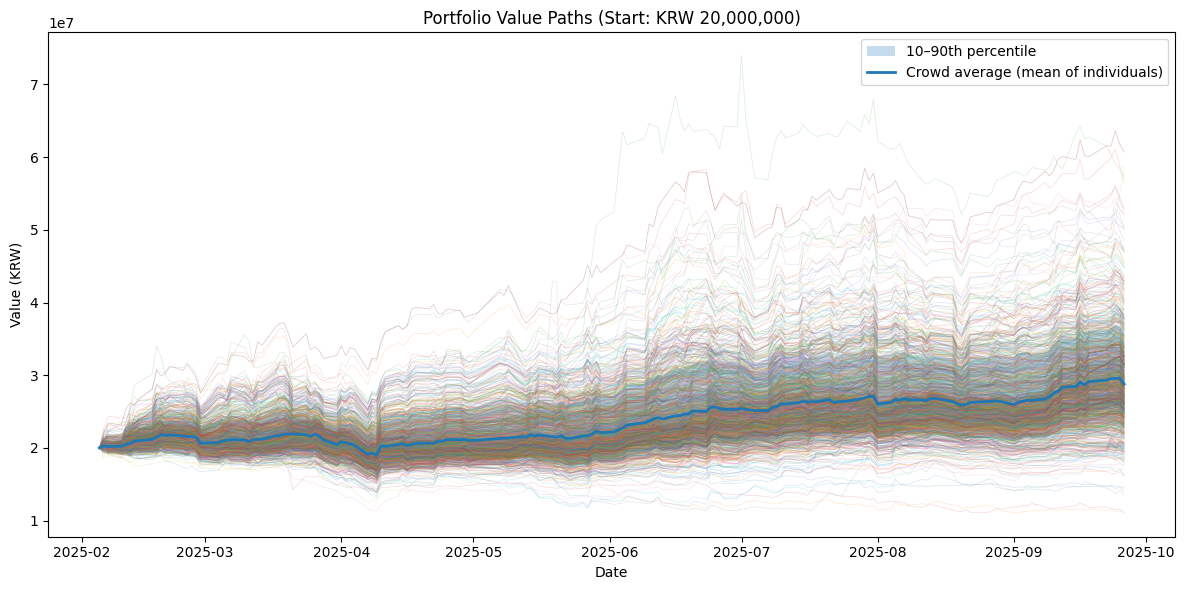

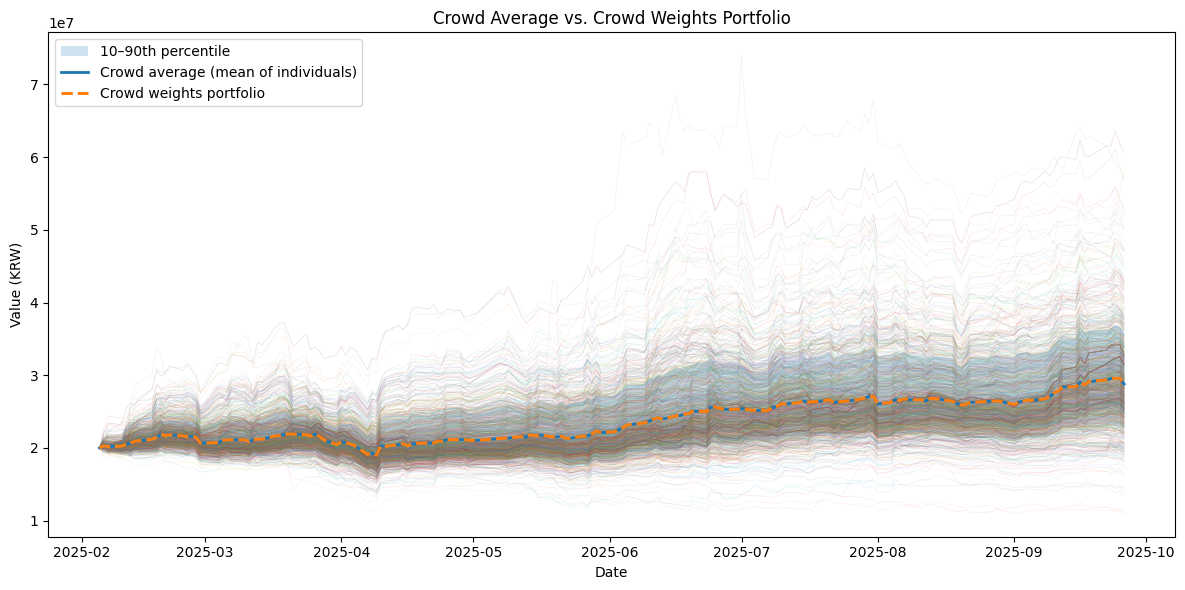


=== Individual Performance (top 10 by AnnReturn) ===
      AnnReturn  AnnVol   Sharpe  TotalReturn     MDD  Days
ID                                                         
166      4.9444  0.5864   8.4323       2.0358 -0.1760   158
730      4.9444  0.5864   8.4323       2.0358 -0.1760   158
744      4.6127  0.4482  10.2910       1.9292 -0.1609   158
83       4.3936  0.5645   7.7831       1.8574 -0.1950   158
507      4.3004  0.7825   5.4956       1.8265 -0.2960   158
1832     3.7744  0.4633   8.1470       1.6483 -0.2000   158
957      3.7232  0.5442   6.8414       1.6306 -0.2062   158
574      3.6760  0.5432   6.7670       1.6142 -0.1779   158
679      3.6171  0.4971   7.2765       1.5937 -0.2181   158
629      3.4099  0.5479   6.2239       1.5205 -0.2026   158


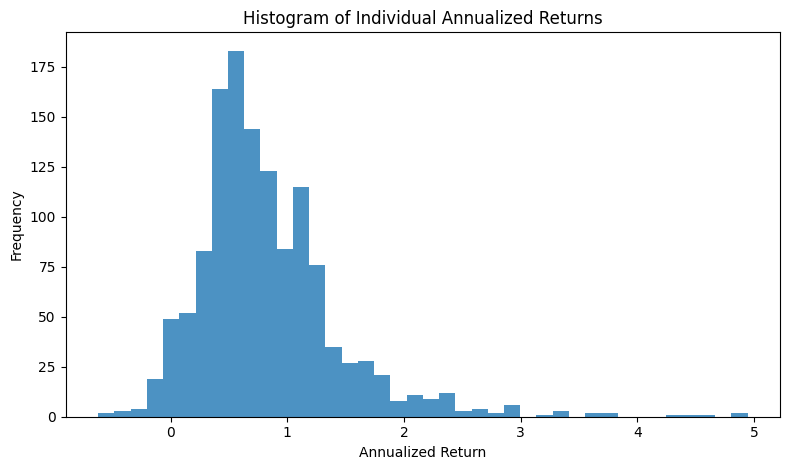


=== Average of Individual Metrics ===
             AverageAcrossIndividuals
AnnReturn                      0.8290
AnnVol                         0.3087
Sharpe                         2.6051
TotalReturn                    0.4391
MDD                           -0.1752
Days                         158.0000

=== Performance Comparison (Individuals, Crowd, Benchmarks) ===
          AnnReturn  AnnVol   Sharpe  TotalReturn     MDD  Days
Name                                                           
IND:744      4.6127  0.4482  10.2910       1.9292 -0.1609   158
IND:166      4.9444  0.5864   8.4323       2.0358 -0.1760   158
IND:730      4.9444  0.5864   8.4323       2.0358 -0.1760   158
IND:1832     3.7744  0.4633   8.1470       1.6483 -0.2000   158
IND:83       4.3936  0.5645   7.7831       1.8574 -0.1950   158
IND:1589     2.3520  0.3109   7.5662       1.1246 -0.1208   158
IND:679      3.6171  0.4971   7.2765       1.5937 -0.2181   158
IND:1444     3.1471  0.4356   7.2247       1.4259 -0.1

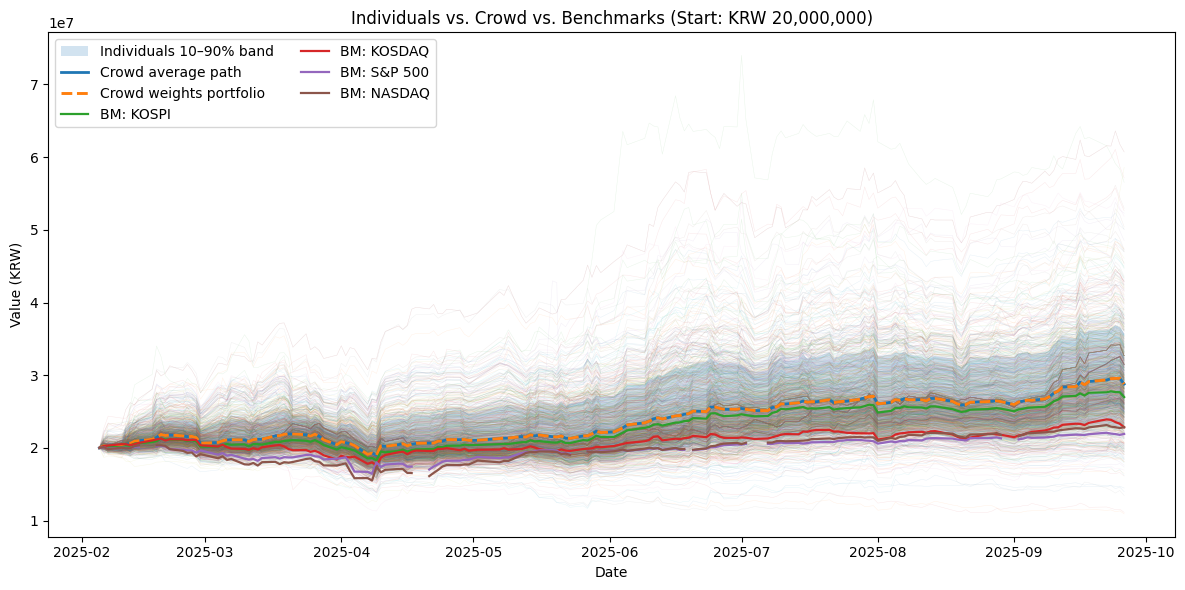

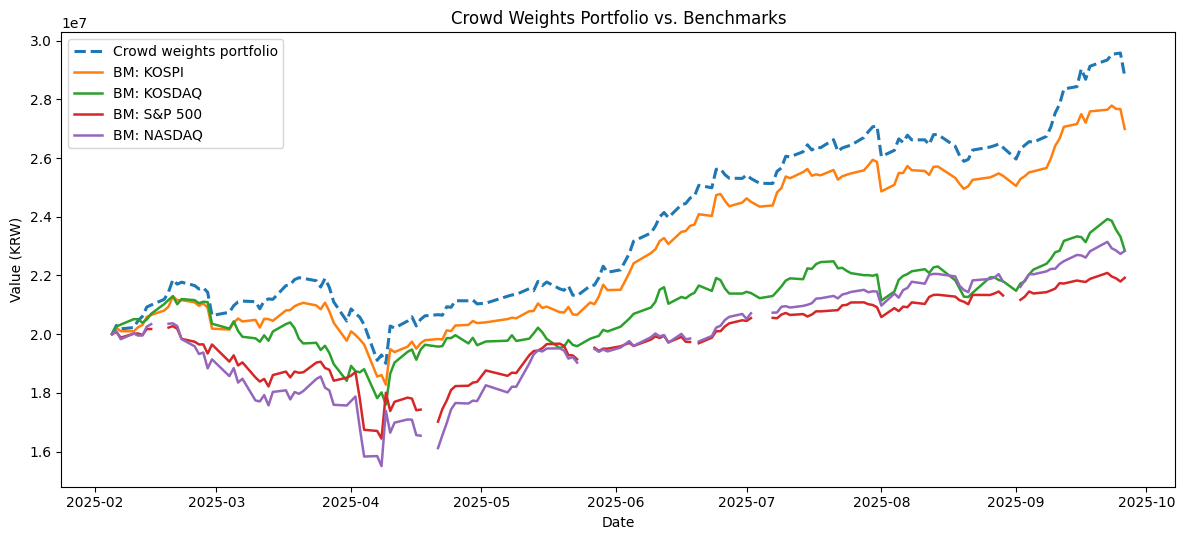

In [ ]:
# ===== Individual NAVs + Crowd Weights Portfolio + Benchmarks + Performance Summary =====
import pandas as pd
import numpy as np
import re, os
import matplotlib.pyplot as plt


# --- put this near the top (after imports) ---
def row_quantile(df: pd.DataFrame, q: float) -> pd.Series:
    """
    Robust row-wise quantile across pandas versions.
    Tries DataFrame.quantile(method='single'), then falls back to interpolation,
    and finally to numpy.nanpercentile via apply (slow but safe).
    """
    # ensure numeric
    df_num = df.apply(pd.to_numeric, errors="coerce")
    try:
        # pandas >= 2.0 uses method in {'single','table'}
        return df_num.quantile(q, axis=1, numeric_only=True, method="single")
    except Exception:
        try:
            # older signatures used 'interpolation'
            return df_num.quantile(q, axis=1, numeric_only=True, interpolation="linear")
        except Exception:
            # final fallback (slow)
            return df_num.apply(lambda r: np.nanpercentile(r.values.astype(float), q * 100), axis=1)



# -------------------
# Paths / Params
# -------------------
DT_CSV      = "dt.csv"         # survey raw
PRICE_CSV   = "price.csv"      # Close time series (Date x Ticker)
OUT_DIR     = "out"
OUT_CSV_ALL = os.path.join(OUT_DIR, "backtest_nav_individual_all.csv")

TOTAL_CAPITAL = 20_000_000     # KRW 20M
EXEC_DATE     = "2015-03-26"   # execution date
OOS_END       = "2025-09-27"   # test end date
RF            = 0.0            # risk-free rate for Sharpe (annual)

os.makedirs(OUT_DIR, exist_ok=True)

# -------------------
# Load data
# -------------------
df_dt  = pd.read_csv(DT_CSV, dtype=str)
prices = pd.read_csv(PRICE_CSV, index_col=0, parse_dates=[0]).sort_index()

# slice test window (exec ~ end)
oos_start = pd.to_datetime(EXEC_DATE)
oos_end   = pd.to_datetime(OOS_END)
prices = prices.loc[(prices.index >= oos_start) & (prices.index <= oos_end)].copy()

# execution day adjust (next valid trading day)
exec_idx = prices.index.get_indexer([oos_start], method="bfill")
if (len(exec_idx) == 0) or (exec_idx[0] == -1):
    raise ValueError("No valid trading day on/after execution date in price.csv")
exec_day = prices.index[exec_idx[0]]

# -------------------
# Helpers
# -------------------
def parse_response(row) -> dict:
    """Extract {ticker: amount in 10k KRW} from a survey row."""
    alloc = {}
    for i in range(1, 16):
        t_col, a_col = f"C1_{i}_2", f"C1_{i}_3"
        if t_col not in row or a_col not in row:
            continue
        t_raw, a_raw = row[t_col], row[a_col]
        if pd.isna(t_raw) or pd.isna(a_raw):
            continue
        t_clean = re.sub(r"[^0-9]", "", str(t_raw))
        if not t_clean:
            continue
        ticker = f"{t_clean.zfill(6)}.KS"
        try:
            amt = float(str(a_raw).replace(",", "").strip())
        except:
            continue
        if amt > 0:
            alloc[ticker] = alloc.get(ticker, 0.0) + amt
    return alloc

def compute_shares_from_weights(weights: dict, px_exec: pd.Series, total_capital: float) -> dict:
    """weights: {ticker: weight}, px_exec: prices at exec_day for those tickers."""
    shares = {}
    for t, w in weights.items():
        px = px_exec.get(t, np.nan)
        if pd.notna(px) and px > 0 and w > 0:
            shares[t] = (total_capital * w) / px
    return shares

def nav_from_shares(shares: dict, prices: pd.DataFrame, exec_day: pd.Timestamp, total_capital: float) -> pd.Series:
    """Compute NAV path from constant shares; scale to exactly total_capital at exec_day."""
    if not shares:
        return None
    tickers = list(shares.keys())
    nav_series = (prices[tickers] * pd.Series(shares)).sum(axis=1)
    nav_series = nav_series.reindex(prices.index)
    if pd.notna(nav_series.loc[exec_day]) and nav_series.loc[exec_day] != 0:
        nav_series = nav_series * (total_capital / nav_series.loc[exec_day])
    nav_series.name = "NAV"
    return nav_series

def perf_metrics_from_nav(nav: pd.Series, rf_annual: float = 0.0) -> dict:
    """Compute performance metrics from NAV path."""
    nav = nav.dropna()
    if nav.shape[0] < 2:
        return {"AnnReturn": np.nan, "AnnVol": np.nan, "Sharpe": np.nan,
                "TotalReturn": np.nan, "MDD": np.nan, "Days": nav.shape[0]}
    rets = nav.pct_change().dropna()
    n = rets.shape[0]
    if n == 0:
        return {"AnnReturn": np.nan, "AnnVol": np.nan, "Sharpe": np.nan,
                "TotalReturn": np.nan, "MDD": np.nan, "Days": nav.shape[0]}
    # annualization by trading days
    total_return = nav.iloc[-1] / nav.iloc[0] - 1.0
    ann_return = (nav.iloc[-1] / nav.iloc[0]) ** (252.0 / n) - 1.0
    ann_vol = rets.std(ddof=1) * np.sqrt(252.0)
    sharpe = (ann_return - rf_annual) / ann_vol if (ann_vol > 0) else np.nan
    cummax = nav.cummax()
    dd = nav / cummax - 1.0
    mdd = dd.min()
    return {
        "AnnReturn": ann_return,
        "AnnVol": ann_vol,
        "Sharpe": sharpe,
        "TotalReturn": total_return,
        "MDD": mdd,
        "Days": int(nav.shape[0]),
    }

# -------------------
# 1) Build all individual NAVs (concat once)
# -------------------
nav_map = {}           # respondent -> NAV series
weights_map = {}       # respondent -> weight dict (normalized, only tickers in prices)
for _, row in df_dt.iterrows():
    if "No" not in row or pd.isna(row["No"]):
        continue
    respondent = str(row["No"]).strip()

    alloc = parse_response(row)
    if not alloc:
        continue
    amt_total = sum(alloc.values())
    if amt_total <= 0:
        continue

    # only tickers available in prices columns
    weights = {t: v / amt_total for t, v in alloc.items() if t in prices.columns}
    if not weights:
        continue
    weights_map[respondent] = weights

    # shares and NAV
    px_exec = prices.loc[exec_day, list(weights.keys())]
    shares = compute_shares_from_weights(weights, px_exec, TOTAL_CAPITAL)
    if not shares:
        continue
    nav = nav_from_shares(shares, prices, exec_day, TOTAL_CAPITAL)
    if nav is None:
        continue
    nav.name = respondent
    nav_map[respondent] = nav

# concat all NAVs
nav_all = pd.concat(nav_map.values(), axis=1) if nav_map else pd.DataFrame(index=prices.index)
nav_all.index.name = "Date"
nav_all.to_csv(OUT_CSV_ALL, encoding="utf-8-sig")
print(f"Saved individual NAVs → {OUT_CSV_ALL} (rows={nav_all.shape[0]}, cols={nav_all.shape[1]})")

# -------------------
# 2) Crowd average path & percentile bands (English labels; no saving)
# -------------------
crowd_avg = nav_all.mean(axis=1, skipna=True)
p10 = row_quantile(nav_all, 0.10)
p90 = row_quantile(nav_all, 0.90)

mask = (~crowd_avg.isna()) & (~p10.isna()) & (~p90.isna())
x = nav_all.index[mask]
y_mean = crowd_avg[mask].values
y_p10  = p10[mask].values
y_p90  = p90[mask].values


plt.figure(figsize=(12, 6))
for col in nav_all.columns:
    plt.plot(nav_all.index, nav_all[col], linewidth=0.5, alpha=0.18)
plt.fill_between(x, y_p10, y_p90, alpha=0.25, label="10–90th percentile")
plt.plot(x, y_mean, linewidth=2.0, label="Crowd average (mean of individuals)")
plt.title("Portfolio Value Paths (Start: KRW 20,000,000)")
plt.xlabel("Date")
plt.ylabel("Value (KRW)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# -------------------
# 3) Crowd weights portfolio (built from average weights) & visualization
# -------------------
w_series_list = []
for resp, w in weights_map.items():
    s = pd.Series(w, name=resp).reindex(prices.columns).fillna(0.0)
    w_series_list.append(s)
if w_series_list:
    W = pd.concat(w_series_list, axis=1)  # rows: tickers, cols: respondents
    w_crowd = W.mean(axis=1)
    w_crowd = w_crowd.where(w_crowd > 0, 0.0)
    if w_crowd.sum() > 0:
        w_crowd = w_crowd / w_crowd.sum()
else:
    w_crowd = pd.Series(dtype=float, index=prices.columns).fillna(0.0)

tickers_crowd = list(w_crowd[w_crowd > 0].index)
px_exec_crowd = prices.loc[exec_day, tickers_crowd] if len(tickers_crowd) else pd.Series(dtype=float)
shares_crowd  = compute_shares_from_weights(w_crowd[w_crowd > 0].to_dict(), px_exec_crowd, TOTAL_CAPITAL)
nav_crowd     = nav_from_shares(shares_crowd, prices, exec_day, TOTAL_CAPITAL) if shares_crowd else None

if nav_crowd is not None:
    plt.figure(figsize=(12, 6))
    for col in nav_all.columns:
        plt.plot(nav_all.index, nav_all[col], linewidth=0.4, alpha=0.12)
    plt.fill_between(x, y_p10, y_p90, alpha=0.22, label="10–90th percentile")
    plt.plot(x, y_mean, linewidth=2.0, label="Crowd average (mean of individuals)")
    plt.plot(nav_crowd.index, nav_crowd.values, linewidth=2.2, linestyle="--", label="Crowd weights portfolio")
    plt.title("Crowd Average vs. Crowd Weights Portfolio")
    plt.xlabel("Date")
    plt.ylabel("Value (KRW)")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# -------------------
# 4) Individual performance metrics table
# -------------------
def perf_from_price_series(px: pd.Series, rf_annual: float = 0.0) -> dict:
    px = px.dropna()
    if px.shape[0] < 2:
        return {"AnnReturn": np.nan, "AnnVol": np.nan, "Sharpe": np.nan,
                "TotalReturn": np.nan, "MDD": np.nan, "Days": px.shape[0]}
    rets = px.pct_change().dropna()
    n = rets.shape[0]
    total_return = px.iloc[-1] / px.iloc[0] - 1.0
    ann_return  = (px.iloc[-1] / px.iloc[0]) ** (252.0 / n) - 1.0
    ann_vol     = rets.std(ddof=1) * np.sqrt(252.0)
    sharpe      = (ann_return - rf_annual) / ann_vol if ann_vol > 0 else np.nan
    cummax      = px.cummax()
    mdd         = (px / cummax - 1.0).min()
    return {
        "AnnReturn": ann_return,
        "AnnVol": ann_vol,
        "Sharpe": sharpe,
        "TotalReturn": total_return,
        "MDD": mdd,
        "Days": int(px.shape[0]),
    }

metrics_rows = []
for col in nav_all.columns:
    m = perf_metrics_from_nav(nav_all[col], rf_annual=RF)
    m["ID"] = col
    metrics_rows.append(m)
df_metrics = pd.DataFrame(metrics_rows).set_index("ID").sort_values("AnnReturn", ascending=False)
print("\n=== Individual Performance (top 10 by AnnReturn) ===")
print(df_metrics.head(10).round(4))

# -------------------
# 5) Histogram of individual annualized returns (English labels; no saving)
# -------------------
plt.figure(figsize=(8, 4.8))
vals = df_metrics["AnnReturn"].dropna().values
plt.hist(vals, bins=40, alpha=0.8)
plt.title("Histogram of Individual Annualized Returns")
plt.xlabel("Annualized Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -------------------
# 6) Average metrics across individuals
# -------------------
avg_metrics = df_metrics.mean(numeric_only=True).to_frame("AverageAcrossIndividuals")
print("\n=== Average of Individual Metrics ===")
print(avg_metrics.round(4))

# -------------------
# 7) Benchmarks: download, visualize, compare
# -------------------
import yfinance as yf

BM_TICKERS = {  # Yahoo Finance index symbols
    "KOSPI": "^KS11",
    "KOSDAQ": "^KQ11",
    "S&P 500": "^GSPC",
    "NASDAQ": "^IXIC",
}

bm_raw = yf.download(
    tickers=list(BM_TICKERS.values()),
    start=str(prices.index.min().date()),
    end=str((prices.index.max() + pd.Timedelta(days=1)).date()),
    interval="1d",
    group_by="ticker",
    auto_adjust=False,
    actions=False,
    progress=False,
    threads=True,
)

def extract_benchmark_close(bm_raw: pd.DataFrame, name_map: dict) -> pd.DataFrame:
    out = pd.DataFrame()
    if isinstance(bm_raw.index, pd.MultiIndex):
        idx = bm_raw.index.get_level_values(0).unique()
        out = pd.DataFrame(index=idx)
    else:
        out = pd.DataFrame(index=pd.to_datetime(bm_raw.index))
    for name, tk in name_map.items():
        s = None
        if isinstance(bm_raw.columns, pd.MultiIndex):
            if tk in bm_raw.columns.get_level_values(0):
                sub = bm_raw[tk]
                if "Close" in sub.columns:
                    s = sub["Close"].rename(name)
        else:
            if "Close" in bm_raw.columns:
                s = bm_raw["Close"].rename(name)
        if s is not None:
            out = out.join(s, how="outer")
    out.index = pd.to_datetime(out.index)
    return out.sort_index()

bm_close = extract_benchmark_close(bm_raw, BM_TICKERS)
bm_close = bm_close.reindex(prices.index).dropna(how="all")

# Benchmark NAV (normalize to TOTAL_CAPITAL)
bm_nav = pd.DataFrame(index=bm_close.index)
for name in bm_close.columns:
    s = bm_close[name].dropna()
    if s.empty:
        continue
    bm_nav[name] = TOTAL_CAPITAL * (s / s.iloc[0])

# Performance comparison table (individuals, crowd, benchmarks)
rows = []
# (a) individuals
for col in nav_all.columns:
    m = perf_metrics_from_nav(nav_all[col], rf_annual=RF)
    m["Name"] = f"IND:{col}"
    rows.append(m)
# (b) crowd average path
m_cavg = perf_from_price_series(crowd_avg, rf_annual=RF)
m_cavg["Name"] = "CrowdAvgPath"
rows.append(m_cavg)
# (c) crowd weights portfolio
if nav_crowd is not None:
    m_cw = perf_metrics_from_nav(nav_crowd, rf_annual=RF)
    m_cw["Name"] = "CrowdWeightsPF"
    rows.append(m_cw)
# (d) benchmarks
for name in bm_nav.columns:
    m_b = perf_from_price_series(bm_nav[name], rf_annual=RF)
    m_b["Name"] = f"BM:{name}"
    rows.append(m_b)

perf_comp = pd.DataFrame(rows).set_index("Name").round(4)
print("\n=== Performance Comparison (Individuals, Crowd, Benchmarks) ===")
print(perf_comp.sort_values(["Sharpe", "AnnReturn"], ascending=False).head(20))

# Visualization: Individuals band + crowd lines + benchmarks
plt.figure(figsize=(12, 6))
# individuals
for col in nav_all.columns:
    plt.plot(nav_all.index, nav_all[col], linewidth=0.35, alpha=0.10)
# band + crowd avg
plt.fill_between(x, y_p10, y_p90, alpha=0.20, label="Individuals 10–90% band")
plt.plot(x, y_mean, linewidth=2.0, label="Crowd average path")
# crowd weights portfolio
if nav_crowd is not None:
    plt.plot(nav_crowd.index, nav_crowd.values, linewidth=2.1, linestyle="--", label="Crowd weights portfolio")
# benchmarks
for name in bm_nav.columns:
    plt.plot(bm_nav.index, bm_nav[name], linewidth=1.6, label=f"BM: {name}")

plt.title("Individuals vs. Crowd vs. Benchmarks (Start: KRW 20,000,000)")
plt.xlabel("Date")
plt.ylabel("Value (KRW)")
plt.legend(loc="best", ncol=2)
plt.tight_layout()
plt.show()

# Visualization: crowd-weights vs. benchmarks (clean view)
plt.figure(figsize=(12, 5.5))
if nav_crowd is not None:
    plt.plot(nav_crowd.index, nav_crowd.values, linewidth=2.2, linestyle="--", label="Crowd weights portfolio")
for name in bm_nav.columns:
    plt.plot(bm_nav.index, bm_nav[name], linewidth=1.8, label=f"BM: {name}")
plt.title("Crowd Weights Portfolio vs. Benchmarks")
plt.xlabel("Date")
plt.ylabel("Value (KRW)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# ---- Notes to diagnose unusually high Sharpe ----
# 1) Short test window or missing/flat data can depress volatility and inflate Sharpe.
# 2) If any fill methods (e.g., forward-fill) were applied on many days, re-check; avoid on price series.
# 3) Check that price.csv has no single-day spikes/drops from bad prints; winsorize if necessary for sensitivity tests.


In [ ]:
# ===== 6 models × 6 performance metrics table =====
from scipy.stats import skew


def perf_with_skew(px: pd.Series, rf_annual: float = 0.0) -> dict:
    """Performance metrics with average return (simple & log)."""
    px = px.dropna()
    if px.shape[0] < 2:
        return {k: np.nan for k in [
            "AvgReturn_Simple", "AvgReturn_Log",
            "Volatility", "Skewness", "Sharpe",
            "TotalReturn", "MDD"
        ]}

    rets = px.pct_change().dropna()
    print('rets', rets)
    log_rets = np.log(px / px.shift(1)).dropna()
    print('rets', log_rets)
    n = rets.shape[0]

    # --- average return: simple & log ---
    mean_r_simple = rets.mean()
    mean_r_log    = log_rets.mean()

    ann_return_simple = mean_r_simple * 252
    ann_return_log    = mean_r_log * 252

    # --- volatility, sharpe, etc. ---
    ann_vol   = rets.std(ddof=1) * np.sqrt(252.0)
    sharpe    = (ann_return_simple - rf_annual) / ann_vol if ann_vol > 0 else np.nan
    skewness  = skew(rets, bias=False) if len(rets) > 0 else np.nan
    total_ret = px.iloc[-1] / px.iloc[0] - 1.0
    cummax    = px.cummax()
    mdd       = (px / cummax - 1.0).min()

    return {
        "AvgReturn_Simple": ann_return_simple,
        "AvgReturn_Log": ann_return_log,
        "Volatility": ann_vol,
        "Skewness": skewness,
        "Sharpe": sharpe,
        "TotalReturn": total_ret,
        "MDD": mdd,
    }


# 6 모델 NAV series 준비
models = {}

# 1) crowd average path (가상의 평균 NAV)
models["CrowdAvgPath"] = crowd_avg

# 2) crowd weight portfolio
if nav_crowd is not None:
    models["CrowdWeightsPF"] = nav_crowd

# 3) kospi
if "KOSPI" in bm_nav.columns:
    models["KOSPI"] = bm_nav["KOSPI"]

# 4) kosdaq
if "KOSDAQ" in bm_nav.columns:
    models["KOSDAQ"] = bm_nav["KOSDAQ"]

# 5) S&P 500
if "S&P 500" in bm_nav.columns:
    models["S&P500"] = bm_nav["S&P 500"]

# 6) NASDAQ
if "NASDAQ" in bm_nav.columns:
    models["NASDAQ"] = bm_nav["NASDAQ"]

# 성과지표 계산
rows = {}
for name, series in models.items():
    print(name)
    print(series)
    print(RF)
    rows[name] = perf_with_skew(series, rf_annual=RF)
    print('===================')
perf_table = pd.DataFrame(rows).T.round(4)  # row=모델, col=metrics
print("\n=== Performance Table (6 models × 6 metrics) ===")
print(perf_table)


CrowdAvgPath
Date
2025-02-05    2.000000e+07
2025-02-06    2.029813e+07
2025-02-07    2.018068e+07
2025-02-10    2.022533e+07
2025-02-11    2.046411e+07
                  ...     
2025-09-22    2.934219e+07
2025-09-23    2.953087e+07
2025-09-24    2.955545e+07
2025-09-25    2.957831e+07
2025-09-26    2.878265e+07
Length: 158, dtype: float64
0.0
rets Date
2025-02-06    0.014907
2025-02-07   -0.005786
2025-02-10    0.002212
2025-02-11    0.011806
2025-02-12    0.006951
                ...   
2025-09-22    0.007416
2025-09-23    0.006430
2025-09-24    0.000832
2025-09-25    0.000773
2025-09-26   -0.026900
Length: 157, dtype: float64
rets Date
2025-02-06    0.014797
2025-02-07   -0.005803
2025-02-10    0.002210
2025-02-11    0.011737
2025-02-12    0.006927
                ...   
2025-09-22    0.007388
2025-09-23    0.006410
2025-09-24    0.000832
2025-09-25    0.000773
2025-09-26   -0.027268
Length: 157, dtype: float64
CrowdWeightsPF
Date
2025-02-05    2.000000e+07
2025-02-06    2.029813e+

In [ ]:
# ===== Benchmark performance sanity-check (last N months) =====
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import skew

# ---------- Params ----------
RF = 0.0         # risk-free for Sharpe (annual)
TRADING_DAYS = 252
MONTHS_BACK = 6   # 240개월 = 20년

# ---------- Helpers ----------
def perf_with_skew(px: pd.Series, rf_annual: float = 0.0) -> dict:
    px = px.dropna()
    if px.shape[0] < 2:
        return {k: np.nan for k in ["AvgReturn_Simple","AvgReturn_Log","Volatility","Skewness","Sharpe","TotalReturn","MDD"]}
    rets = px.pct_change().dropna()
    log_rets = np.log(px / px.shift(1)).dropna()
    n = rets.shape[0]

    mean_r_simple = rets.mean()
    mean_r_log    = log_rets.mean()

    ann_return_simple = mean_r_simple * TRADING_DAYS
    ann_return_log    = mean_r_log * TRADING_DAYS
    ann_vol           = rets.std(ddof=1) * np.sqrt(TRADING_DAYS)
    sharpe            = (ann_return_simple - rf_annual) / ann_vol if ann_vol > 0 else np.nan
    skewness          = skew(rets, bias=False) if len(rets) > 0 else np.nan
    total_ret         = px.iloc[-1] / px.iloc[0] - 1.0
    mdd               = (px / px.cummax() - 1.0).min()

    return {
        "AvgReturn_Simple": ann_return_simple,
        "AvgReturn_Log": ann_return_log,
        "Volatility": ann_vol,
        "Skewness": skewness,
        "Sharpe": sharpe,
        "TotalReturn": total_ret,
        "MDD": mdd,
    }

def extract_close_multi(bm_raw: pd.DataFrame, name_map: dict) -> pd.DataFrame:
    out = pd.DataFrame(index=pd.to_datetime(bm_raw.index))
    for name, tk in name_map.items():
        s = None
        if isinstance(bm_raw.columns, pd.MultiIndex):
            if tk in bm_raw.columns.get_level_values(0):
                sub = bm_raw[tk]
                if "Close" in sub.columns:
                    s = sub["Close"].rename(name)
        else:
            if "Close" in bm_raw.columns:
                s = bm_raw["Close"].rename(name)
        if s is not None:
            out = out.join(s, how="outer")
    return out.sort_index()

# ---------- Pick window ----------
end_date = pd.Timestamp.today().normalize()
start_date = end_date - pd.DateOffset(months=MONTHS_BACK)

# ---------- Yahoo Finance index symbols ----------
BM_TICKERS = {
    "KOSPI": "^KS11",
    "KOSDAQ": "^KQ11",
    "S&P 500": "^GSPC",
    "NASDAQ": "^IXIC",
}

# ---------- Download ----------
bm_raw = yf.download(
    tickers=list(BM_TICKERS.values()),
    start=start_date.strftime("%Y-%m-%d"),
    end=(end_date + pd.Timedelta(days=1)).strftime("%Y-%m-%d"),
    interval="1d",
    group_by="ticker",
    auto_adjust=False,
    actions=False,
    progress=False,
    threads=True,
)

bm_close = extract_close_multi(bm_raw, BM_TICKERS)
bm_close = bm_close.dropna(how="all")

# 교집합 날짜로 정렬
bm_close_inter = bm_close.dropna(how="any").copy()

# ---------- Compute metrics ----------
models = {
    "KOSPI":  bm_close_inter["KOSPI"]  if "KOSPI"  in bm_close_inter.columns else pd.Series(dtype=float),
    "KOSDAQ": bm_close_inter["KOSDAQ"] if "KOSDAQ" in bm_close_inter.columns else pd.Series(dtype=float),
    "S&P500": bm_close_inter["S&P 500"] if "S&P 500" in bm_close_inter.columns else pd.Series(dtype=float),
    "NASDAQ": bm_close_inter["NASDAQ"] if "NASDAQ" in bm_close_inter.columns else pd.Series(dtype=float),
}

rows = {name: perf_with_skew(series, rf_annual=RF) for name, series in models.items() if not series.empty}
perf_table_months = pd.DataFrame(rows).T.round(4)

print(f"\n=== {MONTHS_BACK} Months Benchmark Performance ({start_date.date()} ~ {end_date.date()}) ===")
print(perf_table_months)



=== 6 Months Benchmark Performance (2025-03-29 ~ 2025-09-29) ===
        AvgReturn_Simple  AvgReturn_Log  Volatility  Skewness  Sharpe  \
KOSPI             0.7082         0.6865      0.2046   -0.0702  3.4612   
KOSDAQ            0.5090         0.4867      0.2097   -0.3051  2.4278   
S&P500            0.3854         0.3596      0.2284    1.2928  1.6870   
NASDAQ            0.6032         0.5637      0.2829    1.8233  2.1324   

        TotalReturn     MDD  
KOSPI        0.3829 -0.0903  
KOSDAQ       0.2584 -0.0695  
S&P500       0.1851 -0.1214  
NASDAQ       0.3050 -0.1326  


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import skew

# ===== 기존 함수 재사용 =====
def perf_metrics(nav: pd.Series, rf_annual: float = 0.0, trading_days: int = 252) -> dict:
    nav = nav.dropna()
    if nav.shape[0] < 2:
        return {k: np.nan for k in ["AnnReturn","Volatility","Sharpe","Skewness","TotalReturn","MDD"]}
    rets = nav.pct_change().dropna()
    n = rets.shape[0]

    ann_return = rets.mean() * trading_days
    ann_vol    = rets.std(ddof=1) * np.sqrt(trading_days)
    sharpe     = (ann_return - rf_annual) / ann_vol if ann_vol > 0 else np.nan
    skewness   = skew(rets, bias=False) if len(rets) > 0 else np.nan
    total_ret  = nav.iloc[-1] / nav.iloc[0] - 1.0
    mdd        = (nav / nav.cummax() - 1.0).min()

    return {
        "AnnReturn": ann_return,
        "Volatility": ann_vol,
        "Sharpe": sharpe,
        "Skewness": skewness,
        "TotalReturn": total_ret,
        "MDD": mdd,
    }

def portfolio_paths(prices: pd.DataFrame,
                    weights: dict,
                    exec_day: str,
                    initial_capital: float = 20_000_000):
    """
    Buy&Hold vs Constant-Weight NAV 경로 계산
    """
    exec_day = pd.to_datetime(exec_day)
    px = prices.copy().sort_index()
    px = px.loc[px.index >= exec_day]

    w = pd.Series(weights).reindex(px.columns).fillna(0.0)
    if w.sum() == 0:
        return None, None
    w = w / w.sum()
    px_exec = px.loc[exec_day, w.index]

    # Buy&Hold NAV
    q = (initial_capital * w) / px_exec
    nav_buyhold = (px[w.index] * q).sum(axis=1)
    nav_buyhold.name = "NAV_BuyHold"

    # Constant-Weight NAV
    rets = px[w.index].pct_change().dropna()
    r_pf = (rets * w).sum(axis=1)
    nav_constw = initial_capital * (1 + r_pf).cumprod()
    nav_constw.name = "NAV_ConstWeight"

    return nav_buyhold, nav_constw

# ===== 전체 응답자 루프 =====
def compare_all_individuals(prices: pd.DataFrame,
                            weights_map: dict,
                            exec_day: str,
                            rf_annual: float = 0.0):
    """
    weights_map: {respondent_id: {ticker: weight, ...}, ...}
    """
    results = []

    for resp_id, w in weights_map.items():
        nav_bh, nav_cw = portfolio_paths(prices, w, exec_day)
        if nav_bh is None or nav_cw is None:
            continue
        m_bh = perf_metrics(nav_bh, rf_annual=rf_annual)
        m_cw = perf_metrics(nav_cw, rf_annual=rf_annual)
        m_bh["Method"] = "Buy&Hold"
        m_bh["ID"] = resp_id
        m_cw["Method"] = "ConstWeight"
        m_cw["ID"] = resp_id
        results.append(m_bh)
        results.append(m_cw)

    df_all = pd.DataFrame(results).set_index(["ID", "Method"])
    # 평균 성과
    avg_table = df_all.groupby("Method").mean(numeric_only=True).round(4)
    return df_all, avg_table

# ==== 사용 예시 ====
# weights_map = {
#     "resp1": {"005930.KS":0.5, "000660.KS":0.5},
#     "resp2": {"035420.KS":0.7, "051910.KS":0.3},
#     ...
# }
df_all, avg_table = compare_all_individuals(prices, weights_map, exec_day="2025-03-26")
print("\n=== Individual Results ===")
print(df_all.head())
print("\n=== Average Performance Across Individuals ===")
print(avg_table)



=== Individual Results ===
                AnnReturn  Volatility    Sharpe  Skewness  TotalReturn  \
ID Method                                                                
10 Buy&Hold      0.070562    0.256705  0.274875  0.337665     0.018715   
   ConstWeight  -0.056030    0.255025 -0.219702  0.337739    -0.041803   
11 Buy&Hold      0.898941    0.377856  2.379058  0.079827     0.497326   
   ConstWeight   0.972156    0.379789  2.559723  0.041868     0.545527   
12 Buy&Hold      0.960677    0.400553  2.398379  0.085379     0.536449   

                     MDD  
ID Method                 
10 Buy&Hold    -0.108513  
   ConstWeight -0.113219  
11 Buy&Hold    -0.228610  
   ConstWeight -0.222073  
12 Buy&Hold    -0.145378  

=== Average Performance Across Individuals ===
             AnnReturn  Volatility  Sharpe  Skewness  TotalReturn     MDD
Method                                                                   
Buy&Hold        0.5680      0.3099  1.8253    0.2320       0.3005 -0

Individual Buy&Hold NAVs: 1280 portfolios

=== Average of Individual Buy&Hold Metrics ===
AvgReturn_Simple: 0.5680
AvgReturn_Log: 0.5168
Volatility: 0.3099
Skewness: 0.2320
Sharpe: 1.8253
TotalReturn: 0.3005
MDD: -0.1535

ChatGPT Portfolio: 10 stocks (equal weight 12.5% each)

=== Performance Comparison Table ===
                        AvgReturn_Simple  AvgReturn_Log  Volatility  Skewness  \
KOSPI                             0.5286         0.5069      0.2072   -0.0705   
ChatGPT_EqualWeight               0.4225         0.3969      0.2262    0.0599   
NASDAQ                            0.5276         0.4870      0.2871    1.7753   
Avg_Individual_BuyHold            0.5680         0.5168      0.3099    0.2320   
KOSDAQ                            0.3371         0.3141      0.2143   -0.2503   
S&P500                            0.3490         0.3226      0.2311    1.2658   

                        Sharpe  TotalReturn     MDD  
KOSPI                   2.5511       0.2807 -0.1325  
ChatGPT_E

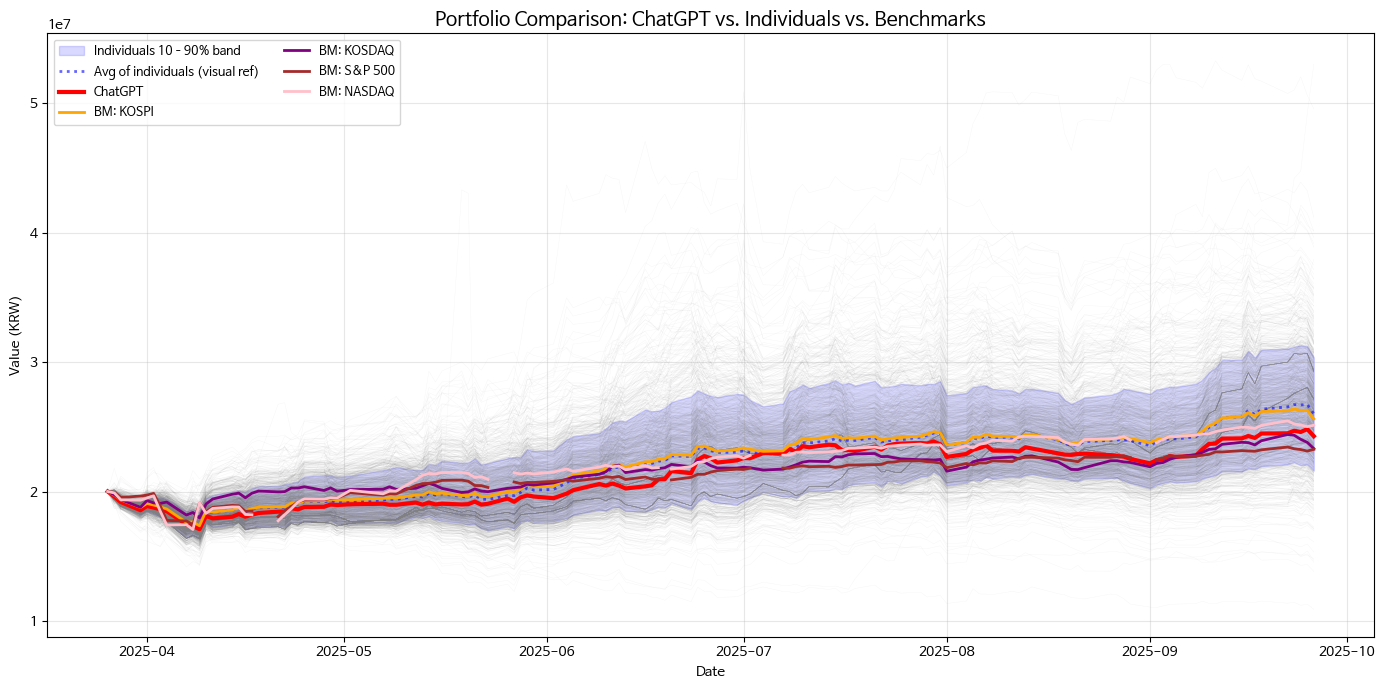

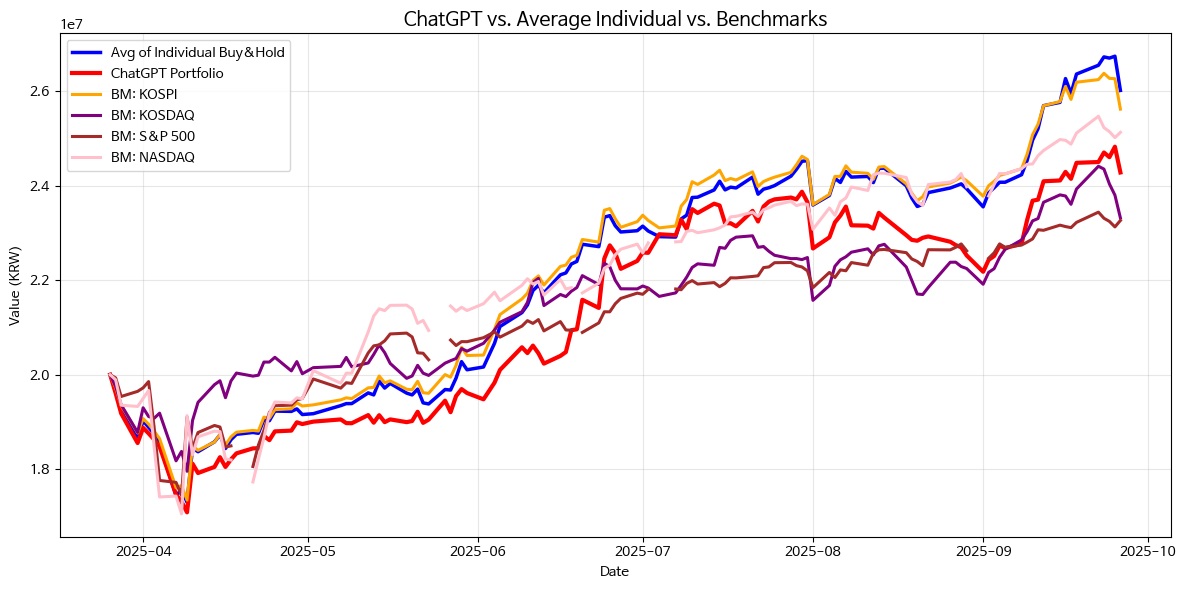

In [ ]:
# ===== Individual Buy&Hold Average + ChatGPT Portfolio + Benchmarks =====
import pandas as pd
import numpy as np
import re, os
import matplotlib.pyplot as plt
from scipy.stats import skew

# --- Robust quantile function ---
def row_quantile(df: pd.DataFrame, q: float) -> pd.Series:
    """Robust row-wise quantile across pandas versions."""
    df_num = df.apply(pd.to_numeric, errors="coerce")
    try:
        return df_num.quantile(q, axis=1, numeric_only=True, method="single")
    except Exception:
        try:
            return df_num.quantile(q, axis=1, numeric_only=True, interpolation="linear")
        except Exception:
            return df_num.apply(lambda r: np.nanpercentile(r.values.astype(float), q * 100), axis=1)

# -------------------
# Paths / Params
# -------------------
DT_CSV      = "dt.csv"
PRICE_CSV   = "price.csv"
OUT_DIR     = "out"

TOTAL_CAPITAL = 20_000_000
EXEC_DATE     = "2025-03-26"
OOS_END       = "2025-09-27"
RF            = 0.0

os.makedirs(OUT_DIR, exist_ok=True)

# -------------------
# ChatGPT Portfolio Weights (8 stocks, equal weight)
# -------------------
CHATGPT_WEIGHTS = {
    '005930.KS': 0.15,   # 삼성전자
    '000660.KS': 0.10,   # SK하이닉스
    '051910.KS': 0.10,   # LG화학
    '005380.KS': 0.10,   # 현대자동차
    '207940.KS': 0.10,   # 삼성바이오로직스
    '035420.KS': 0.10,   # NAVER
    '005490.KS': 0.10,   # POSCO홀딩스
    '105560.KS': 0.10,   # KB금융
    '015760.KS': 0.075,  # 한국전력공사
    '090430.KS': 0.075,  # 아모레퍼시픽
}


# -------------------
# Load data
# -------------------
df_dt  = pd.read_csv(DT_CSV, dtype=str)
prices = pd.read_csv(PRICE_CSV, index_col=0, parse_dates=[0]).sort_index()

# slice test window
oos_start = pd.to_datetime(EXEC_DATE)
oos_end   = pd.to_datetime(OOS_END)
prices = prices.loc[(prices.index >= oos_start) & (prices.index <= oos_end)].copy()

# execution day adjust
exec_idx = prices.index.get_indexer([oos_start], method="bfill")
if (len(exec_idx) == 0) or (exec_idx[0] == -1):
    raise ValueError("No valid trading day on/after execution date in price.csv")
exec_day = prices.index[exec_idx[0]]

# -------------------
# Helpers
# -------------------
def parse_response(row) -> dict:
    """Extract {ticker: amount in 10k KRW} from a survey row."""
    alloc = {}
    for i in range(1, 16):
        t_col, a_col = f"C1_{i}_2", f"C1_{i}_3"
        if t_col not in row or a_col not in row:
            continue
        t_raw, a_raw = row[t_col], row[a_col]
        if pd.isna(t_raw) or pd.isna(a_raw):
            continue
        t_clean = re.sub(r"[^0-9]", "", str(t_raw))
        if not t_clean:
            continue
        ticker = f"{t_clean.zfill(6)}.KS"
        try:
            amt = float(str(a_raw).replace(",", "").strip())
        except:
            continue
        if amt > 0:
            alloc[ticker] = alloc.get(ticker, 0.0) + amt
    return alloc

def compute_shares_from_weights(weights: dict, px_exec: pd.Series, total_capital: float) -> dict:
    """weights: {ticker: weight}, px_exec: prices at exec_day for those tickers."""
    shares = {}
    for t, w in weights.items():
        px = px_exec.get(t, np.nan)
        if pd.notna(px) and px > 0 and w > 0:
            shares[t] = (total_capital * w) / px
    return shares

def nav_from_shares(shares: dict, prices: pd.DataFrame, exec_day: pd.Timestamp, total_capital: float) -> pd.Series:
    """Compute NAV path from constant shares (Buy&Hold); scale to exactly total_capital at exec_day."""
    if not shares:
        return None
    tickers = list(shares.keys())
    nav_series = (prices[tickers] * pd.Series(shares)).sum(axis=1)
    nav_series = nav_series.reindex(prices.index)
    if pd.notna(nav_series.loc[exec_day]) and nav_series.loc[exec_day] != 0:
        nav_series = nav_series * (total_capital / nav_series.loc[exec_day])
    nav_series.name = "NAV"
    return nav_series

def perf_with_skew(px: pd.Series, rf_annual: float = 0.0) -> dict:
    """Performance metrics with average return (simple & log)."""
    px = px.dropna()
    if px.shape[0] < 2:
        return {k: np.nan for k in [
            "AvgReturn_Simple", "AvgReturn_Log",
            "Volatility", "Skewness", "Sharpe",
            "TotalReturn", "MDD"
        ]}

    rets = px.pct_change().dropna()
    log_rets = np.log(px / px.shift(1)).dropna()

    mean_r_simple = rets.mean()
    mean_r_log    = log_rets.mean()

    ann_return_simple = mean_r_simple * 252
    ann_return_log    = mean_r_log * 252

    ann_vol   = rets.std(ddof=1) * np.sqrt(252.0)
    sharpe    = (ann_return_simple - rf_annual) / ann_vol if ann_vol > 0 else np.nan
    skewness  = skew(rets, bias=False) if len(rets) > 0 else np.nan
    total_ret = px.iloc[-1] / px.iloc[0] - 1.0
    cummax    = px.cummax()
    mdd       = (px / cummax - 1.0).min()

    return {
        "AvgReturn_Simple": ann_return_simple,
        "AvgReturn_Log": ann_return_log,
        "Volatility": ann_vol,
        "Skewness": skewness,
        "Sharpe": sharpe,
        "TotalReturn": total_ret,
        "MDD": mdd,
    }

# -------------------
# 1) Build all individual Buy&Hold NAVs
# -------------------
nav_map = {}
weights_map = {}

for _, row in df_dt.iterrows():
    if "No" not in row or pd.isna(row["No"]):
        continue
    respondent = str(row["No"]).strip()

    alloc = parse_response(row)
    if not alloc:
        continue
    amt_total = sum(alloc.values())
    if amt_total <= 0:
        continue

    # only tickers available in prices columns
    weights = {t: v / amt_total for t, v in alloc.items() if t in prices.columns}
    if not weights:
        continue
    weights_map[respondent] = weights

    # Buy&Hold shares and NAV
    px_exec = prices.loc[exec_day, list(weights.keys())]
    shares = compute_shares_from_weights(weights, px_exec, TOTAL_CAPITAL)
    if not shares:
        continue
    nav = nav_from_shares(shares, prices, exec_day, TOTAL_CAPITAL)
    if nav is None:
        continue
    nav.name = respondent
    nav_map[respondent] = nav

# concat all individual Buy&Hold NAVs
nav_all = pd.concat(nav_map.values(), axis=1) if nav_map else pd.DataFrame(index=prices.index)
nav_all.index.name = "Date"
print(f"Individual Buy&Hold NAVs: {nav_all.shape[1]} portfolios")

# -------------------
# 2) Average of individual Buy&Hold performance (비교방법론)
# -------------------
individual_metrics = []
for col in nav_all.columns:
    m = perf_with_skew(nav_all[col], rf_annual=RF)
    individual_metrics.append(m)

df_individual_metrics = pd.DataFrame(individual_metrics)
avg_individual_perf = df_individual_metrics.mean(numeric_only=True).to_dict()

print("\n=== Average of Individual Buy&Hold Metrics ===")
for k, v in avg_individual_perf.items():
    print(f"{k}: {v:.4f}")

# -------------------
# 3) ChatGPT Portfolio (Buy&Hold)
# -------------------
chatgpt_weights_filtered = {t: w for t, w in CHATGPT_WEIGHTS.items() if t in prices.columns}
if chatgpt_weights_filtered:
    total_w = sum(chatgpt_weights_filtered.values())
    chatgpt_weights_normalized = {t: w/total_w for t, w in chatgpt_weights_filtered.items()}

    px_exec_gpt = prices.loc[exec_day, list(chatgpt_weights_normalized.keys())]
    shares_gpt = compute_shares_from_weights(chatgpt_weights_normalized, px_exec_gpt, TOTAL_CAPITAL)
    nav_gpt = nav_from_shares(shares_gpt, prices, exec_day, TOTAL_CAPITAL) if shares_gpt else None

    print(f"\nChatGPT Portfolio: {len(chatgpt_weights_normalized)} stocks (equal weight 12.5% each)")
else:
    nav_gpt = None
    print("\nWarning: No ChatGPT portfolio tickers found in price data")

# -------------------
# 4) Benchmarks
# -------------------
import yfinance as yf

BM_TICKERS = {
    "KOSPI": "^KS11",
    "KOSDAQ": "^KQ11",
    "S&P 500": "^GSPC",
    "NASDAQ": "^IXIC",
}

bm_raw = yf.download(
    tickers=list(BM_TICKERS.values()),
    start=str(prices.index.min().date()),
    end=str((prices.index.max() + pd.Timedelta(days=1)).date()),
    interval="1d",
    group_by="ticker",
    auto_adjust=False,
    actions=False,
    progress=False,
    threads=True,
)

def extract_benchmark_close(bm_raw: pd.DataFrame, name_map: dict) -> pd.DataFrame:
    out = pd.DataFrame()
    if isinstance(bm_raw.index, pd.MultiIndex):
        idx = bm_raw.index.get_level_values(0).unique()
        out = pd.DataFrame(index=idx)
    else:
        out = pd.DataFrame(index=pd.to_datetime(bm_raw.index))
    for name, tk in name_map.items():
        s = None
        if isinstance(bm_raw.columns, pd.MultiIndex):
            if tk in bm_raw.columns.get_level_values(0):
                sub = bm_raw[tk]
                if "Close" in sub.columns:
                    s = sub["Close"].rename(name)
        else:
            if "Close" in bm_raw.columns:
                s = bm_raw["Close"].rename(name)
        if s is not None:
            out = out.join(s, how="outer")
    out.index = pd.to_datetime(out.index)
    return out.sort_index()

bm_close = extract_benchmark_close(bm_raw, BM_TICKERS)
bm_close = bm_close.reindex(prices.index).dropna(how="all")

# Benchmark NAV
bm_nav = pd.DataFrame(index=bm_close.index)
for name in bm_close.columns:
    s = bm_close[name].dropna()
    if s.empty:
        continue
    bm_nav[name] = TOTAL_CAPITAL * (s / s.iloc[0])

# -------------------
# 5) Performance Table (6 models)
# -------------------
models = {}

# 1) Average of Individual Buy&Hold (비교방법론)
models["Avg_Individual_BuyHold"] = avg_individual_perf

# 2) ChatGPT portfolio
if nav_gpt is not None:
    models["ChatGPT_EqualWeight"] = perf_with_skew(nav_gpt, rf_annual=RF)

# 3-6) Benchmarks
if "KOSPI" in bm_nav.columns:
    models["KOSPI"] = perf_with_skew(bm_nav["KOSPI"], rf_annual=RF)
if "KOSDAQ" in bm_nav.columns:
    models["KOSDAQ"] = perf_with_skew(bm_nav["KOSDAQ"], rf_annual=RF)
if "S&P 500" in bm_nav.columns:
    models["S&P500"] = perf_with_skew(bm_nav["S&P 500"], rf_annual=RF)
if "NASDAQ" in bm_nav.columns:
    models["NASDAQ"] = perf_with_skew(bm_nav["NASDAQ"], rf_annual=RF)

# Create performance table
perf_table = pd.DataFrame(models).T.round(4)
print("\n=== Performance Comparison Table ===")
print(perf_table.sort_values("Sharpe", ascending=False))

# Save to CSV
perf_table.to_csv(os.path.join(OUT_DIR, "performance_comparison.csv"), encoding="utf-8-sig")

# -------------------
# 6) Visualization: ChatGPT vs Average Individual vs Benchmarks
# -------------------
# Individual band for reference
p10 = row_quantile(nav_all, 0.10)
p90 = row_quantile(nav_all, 0.90)
crowd_avg = nav_all.mean(axis=1, skipna=True)

mask = (~crowd_avg.isna()) & (~p10.isna()) & (~p90.isna())
x = nav_all.index[mask]
y_mean = crowd_avg[mask].values
y_p10  = p10[mask].values
y_p90  = p90[mask].values

plt.figure(figsize=(14, 7))

# Individual portfolios (background)
for col in nav_all.columns:
    plt.plot(nav_all.index, nav_all[col], linewidth=0.3, alpha=0.08, color='gray')

# Individual band
plt.fill_between(x, y_p10, y_p90, alpha=0.15, color='blue', label="Individuals 10–90% band")

# Average of individuals (for visual reference)
plt.plot(x, y_mean, linewidth=2.0, color='blue', linestyle=':', alpha=0.6, label="Avg of individuals (visual ref)")

# ChatGPT
if nav_gpt is not None:
    plt.plot(nav_gpt.index, nav_gpt.values, linewidth=3.0,
             color='red', label="ChatGPT")

# Benchmarks
colors = {'KOSPI': 'orange', 'KOSDAQ': 'purple', 'S&P 500': 'brown', 'NASDAQ': 'pink'}
for name in bm_nav.columns:
    plt.plot(bm_nav.index, bm_nav[name], linewidth=2.0,
             color=colors.get(name, 'black'), label=f"BM: {name}")

plt.title("Portfolio Comparison: ChatGPT vs. Individuals vs. Benchmarks", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Value (KRW)")
plt.legend(loc="best", ncol=2, fontsize=9)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "portfolio_comparison.png"), dpi=150)
plt.show()

# -------------------
# 7) Clean comparison: ChatGPT vs Average Individual vs Benchmarks
# -------------------
plt.figure(figsize=(12, 6))

# Average of individuals
plt.plot(x, y_mean, linewidth=2.5, color='blue',
         label="Avg of Individual Buy&Hold")

# ChatGPT
if nav_gpt is not None:
    plt.plot(nav_gpt.index, nav_gpt.values, linewidth=3.0,
             color='red', label="ChatGPT Portfolio")

# Benchmarks
for name in bm_nav.columns:
    plt.plot(bm_nav.index, bm_nav[name], linewidth=2.2,
             color=colors.get(name, 'black'), label=f"BM: {name}")

plt.title("ChatGPT vs. Average Individual vs. Benchmarks", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Value (KRW)")
plt.legend(loc="best", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "chatgpt_vs_avg_vs_benchmarks.png"), dpi=150)
plt.show()

In [2]:
# ===== Benchmark performance sanity-check (last N months) =====
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.stats import skew

# ---------- Params ----------
RF = 0.0         # risk-free for Sharpe (annual)
TRADING_DAYS = 252
MONTHS_BACK = 120   # 240개월 = 20년

# ---------- Helpers ----------
def perf_with_skew(px: pd.Series, rf_annual: float = 0.0) -> dict:
    px = px.dropna()
    if px.shape[0] < 2:
        return {k: np.nan for k in ["AvgReturn_Simple","AvgReturn_Log","Volatility","Skewness","Sharpe","TotalReturn","MDD"]}
    rets = px.pct_change().dropna()
    log_rets = np.log(px / px.shift(1)).dropna()
    n = rets.shape[0]

    mean_r_simple = rets.mean()
    mean_r_log    = log_rets.mean()

    ann_return_simple = mean_r_simple * TRADING_DAYS
    ann_return_log    = mean_r_log * TRADING_DAYS
    ann_vol           = rets.std(ddof=1) * np.sqrt(TRADING_DAYS)
    sharpe            = (ann_return_simple - rf_annual) / ann_vol if ann_vol > 0 else np.nan
    skewness          = skew(rets, bias=False) if len(rets) > 0 else np.nan
    total_ret         = px.iloc[-1] / px.iloc[0] - 1.0
    mdd               = (px / px.cummax() - 1.0).min()

    return {
        "AvgReturn_Simple": ann_return_simple,
        "AvgReturn_Log": ann_return_log,
        "Volatility": ann_vol,
        "Skewness": skewness,
        "Sharpe": sharpe,
        "TotalReturn": total_ret,
        "MDD": mdd,
    }

def extract_close_multi(bm_raw: pd.DataFrame, name_map: dict) -> pd.DataFrame:
    out = pd.DataFrame(index=pd.to_datetime(bm_raw.index))
    for name, tk in name_map.items():
        s = None
        if isinstance(bm_raw.columns, pd.MultiIndex):
            if tk in bm_raw.columns.get_level_values(0):
                sub = bm_raw[tk]
                if "Close" in sub.columns:
                    s = sub["Close"].rename(name)
        else:
            if "Close" in bm_raw.columns:
                s = bm_raw["Close"].rename(name)
        if s is not None:
            out = out.join(s, how="outer")
    return out.sort_index()

# ---------- Pick window ----------
end_date = pd.Timestamp.today().normalize()
start_date = end_date - pd.DateOffset(months=MONTHS_BACK)

# ---------- Yahoo Finance index symbols ----------
BM_TICKERS = {
    "KOSPI": "^KS11",
    "KOSDAQ": "^KQ11",
    "S&P 500": "^GSPC",
    "NASDAQ": "^IXIC",
}

# ---------- Download ----------
bm_raw = yf.download(
    tickers=list(BM_TICKERS.values()),
    start=start_date.strftime("%Y-%m-%d"),
    end=(end_date + pd.Timedelta(days=1)).strftime("%Y-%m-%d"),
    interval="1d",
    group_by="ticker",
    auto_adjust=False,
    actions=False,
    progress=False,
    threads=True,
)

bm_close = extract_close_multi(bm_raw, BM_TICKERS)
bm_close = bm_close.dropna(how="all")

# 교집합 날짜로 정렬
bm_close_inter = bm_close.dropna(how="any").copy()

# ---------- Compute metrics ----------
models = {
    "KOSPI":  bm_close_inter["KOSPI"]  if "KOSPI"  in bm_close_inter.columns else pd.Series(dtype=float),
    "KOSDAQ": bm_close_inter["KOSDAQ"] if "KOSDAQ" in bm_close_inter.columns else pd.Series(dtype=float),
    "S&P500": bm_close_inter["S&P 500"] if "S&P 500" in bm_close_inter.columns else pd.Series(dtype=float),
    "NASDAQ": bm_close_inter["NASDAQ"] if "NASDAQ" in bm_close_inter.columns else pd.Series(dtype=float),
}

rows = {name: perf_with_skew(series, rf_annual=RF) for name, series in models.items() if not series.empty}
perf_table_months = pd.DataFrame(rows).T.round(4)

print(f"\n=== {MONTHS_BACK} Months Benchmark Performance ({start_date.date()} ~ {end_date.date()}) ===")
print(perf_table_months)




=== 120 Months Benchmark Performance (2015-09-30 ~ 2025-09-30) ===
        AvgReturn_Simple  AvgReturn_Log  Volatility  Skewness  Sharpe  \
KOSPI             0.0748         0.0594      0.1753   -0.2465  0.4265   
KOSDAQ            0.0515         0.0235      0.2357   -0.5897  0.2185   
S&P500            0.1497         0.1322      0.1863   -0.3275  0.8032   
NASDAQ            0.1939         0.1687      0.2241   -0.2050  0.8653   

        TotalReturn     MDD  
KOSPI        0.7481 -0.4390  
KOSDAQ       0.2480 -0.5379  
S&P500       2.4693 -0.3392  
NASDAQ       3.8897 -0.3640  
